In [11]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import jax
from jax import random, numpy as jnp
from flax.core import pop
import flax.linen as nn
from fxlayers.layers import GDNControl

/Users/jorgvt/Developer/dn_exploration/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Defining and initializing the model

In [2]:
from paramperceptnet.layers import GaborLayerGammaHumanLike_
from fxlayers.layers import pad_same_from_kernel_size

class Model(nn.Module):
    @nn.compact
    def __call__(self, inputs, **kwargs):
        outputs = nn.max_pool(inputs, window_shape=(2,2), strides=(2,2))
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = pad_same_from_kernel_size(outputs, kernel_size=31, mode="symmetric")
        outputs, fmean, theta_mean = GaborLayerGammaHumanLike_(
            n_scales=[4, 2, 2],
            n_orientations=[8, 8, 8],
            kernel_size=31,
            fs=32,
            xmean=32 / 32 / 2,
            ymean=32 / 32 / 2,
            strides=1,
            padding="VALID",
            normalize_prob=False,
            normalize_energy=True,
            zero_mean=True,
            use_bias=False,
            train_A=False,
        )(outputs, return_freq=True, return_theta=True, **kwargs)
        outputs = GDNControl(kernel_size=31, fs=31, normalize_prob=False, normalize_energy=False, normalize_sum=True)(outputs, fmean, theta_mean, **kwargs)
        return outputs

In [3]:
from flax.core import pop

model = Model()
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(1,256,256,3))
variables = model.init(key2, x)
state, params = pop(variables, "params")
pred, state = model.apply({"params": params, **state}, x, train=True, mutable=list(state.keys()))
pred.shape

(1, 64, 64, 128)

In [4]:
params["GaborLayerGammaHumanLike__0"]["freq_a"] = jnp.array([2.0, 4., 8., 16.])
params["GaborLayerGammaHumanLike__0"]["freq_t"] = jnp.array([2., 4.])
params["GaborLayerGammaHumanLike__0"]["freq_d"] = jnp.array([2., 4.])

A_a = jnp.zeros(shape=(3, 64), dtype=jnp.float32)
A_a = A_a.at[0, :].set(1.0)
A_t = jnp.zeros(shape=(3, 32), dtype=jnp.float32)
A_t = A_t.at[1, :].set(1.0)
A_d = jnp.zeros(shape=(3, 32), dtype=jnp.float32)
A_d = A_d.at[2, :].set(1.0)
params["GaborLayerGammaHumanLike__0"]["A"] = jnp.concatenate(
    [A_a, A_t, A_d], axis=-1
)
params["GaborLayerGammaHumanLike__0"]["gammax_a"] = 3*jnp.array([2,4,8,16])
params["GaborLayerGammaHumanLike__0"]["gammay_a"] = 3*jnp.array([2,4,8,16])

In [6]:
params["GDNControl_0"]["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["H_cc"] = jnp.eye(3,3)

params["GDNControl_0"]["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_a"] = params["GDNControl_0"]["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_a"]*(1/(20*jnp.pi/180))
params["GDNControl_0"]["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_t"] = params["GDNControl_0"]["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_t"]*(1/(20*jnp.pi/180))
params["GDNControl_0"]["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_d"] = params["GDNControl_0"]["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_d"]*(1/(20*jnp.pi/180))

params["GDNControl_0"]["GDNSpatioChromaFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.array([1/0.2]*128)

inputs_star = jnp.load("a_star_gdn_control.npy")
params["GDNControl_0"]["GDNSpatioChromaFreqOrient_0"]["bias"] = (inputs_star.squeeze()**2)/1000
# params["GDNControl_0"]["GDNSpatioChromaFreqOrient_0"]["bias"] = jnp.array([0]*128)
state["batch_stats"]["GDNControl_0"]["inputs_star"] = inputs_star
state["batch_stats"]["GDNControl_0"]["K"] = inputs_star

In [7]:
params["GDNControl_0"]["GDNSpatioChromaFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.concatenate([
    jnp.tile(jnp.tile(params["GaborLayerGammaHumanLike__0"]["gammax_a"], reps=8), reps=2),
    jnp.tile(jnp.tile(params["GaborLayerGammaHumanLike__0"]["gammax_t"], reps=8), reps=2),
    jnp.tile(jnp.tile(params["GaborLayerGammaHumanLike__0"]["gammax_d"], reps=8), reps=2),
])

## Loading data

In [15]:
from perceptualtests.color_matrices import Mng2xyz, Mxyz2atd, gamma
# def rgb2atd(img):

def rgb2atd(img):
    return img**(1/gamma) @ Mng2xyz.T @ Mxyz2atd.T

In [13]:
@jax.jit
def calculate_diffs(img1, img2):
    pred1 = model.apply({"params": params, **state}, img1, train=False)
    pred2 = model.apply({"params": params, **state}, img2, train=False)
    return ((pred1-pred2)**2).sum(axis=(1,2,3))**(1/2)

### Prop 6-7

In [28]:
import numpy as np
data = np.load("/Users/jorgvt/Developer/visturing/Data/Experiment_6_7/gabor_no_noise_achrom.py.npy")
contrasts = np.load("/Users/jorgvt/Developer/visturing/Data/Experiment_6_7/contrast_a.npy")
print(data.shape)
print(contrasts)

(5, 21, 256, 256, 3)
[0.         0.00173698 0.00301709 0.00524061 0.00910282 0.01581139
 0.025      0.02746401 0.04770435 0.05       0.075      0.08286135
 0.1        0.125      0.14392824 0.15       0.175      0.2
 0.225      0.25       0.25      ]


In [29]:
results = []

for dat in tqdm(data):
    dat = rgb2atd(dat)
    # pred, extras = model.apply({"params": params, **state}, dat, train=True, mutable=list(state.keys()), capture_intermediates=True)
    # diff = ((pred - pred[0:1])**2).sum(axis=(1,2,3))**(1/2)
    # diff = calculate_diffs(dat, dat[0:1])
    diff = calculate_diffs(dat, dat[0:1])
    results.append(diff)
    # break


100%|██████████| 5/5 [00:01<00:00,  4.08it/s]


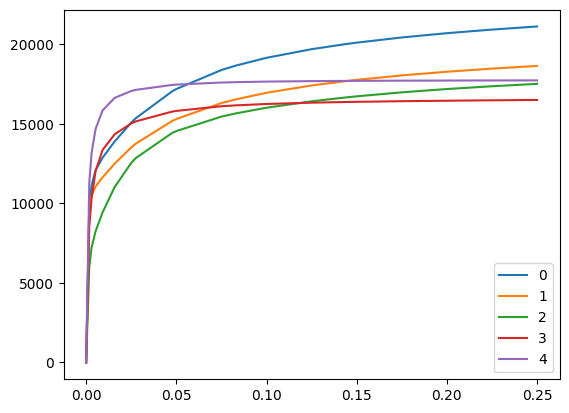

In [30]:
for i, r in enumerate(results):
    # plt.plot(contrasts[:-5], r, label=i)
    plt.plot(contrasts, r, label=i)
    # plt.plot(r)
plt.legend()
plt.show()

### Prop 8

In [14]:
import numpy as np
data = np.load("/Users/jorgvt/Developer/visturing/Data/Experiment_8/gabors_low_achrom.npy")
contrasts = np.load("/Users/jorgvt/Developer/visturing/Data/Experiment_8/contrasts.npy")
print(data.shape)
print(contrasts)

(5, 20, 256, 256, 3)
[0.         0.00173698 0.00301709 0.00524061 0.00910282 0.01581139
 0.025      0.02746401 0.04770435 0.05       0.075      0.08286135
 0.1        0.125      0.14392824 0.15       0.175      0.2
 0.225      0.25      ]


In [16]:
results = []

for dat in tqdm(data):
    dat = rgb2atd(dat)
    # pred, extras = model.apply({"params": params, **state}, dat, train=True, mutable=list(state.keys()), capture_intermediates=True)
    # diff = ((pred - pred[0:1])**2).sum(axis=(1,2,3))**(1/2)
    # diff = calculate_diffs(dat, dat[0:1])
    diff = calculate_diffs(dat, dat[0:1])
    results.append(diff)
    # break


100%|██████████| 5/5 [00:01<00:00,  4.64it/s]


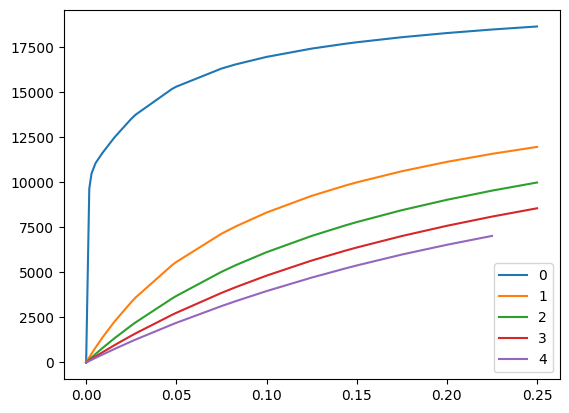

In [17]:
for i, r in enumerate(results):
    # plt.plot(contrasts[:-5], r, label=i)
    plt.plot(contrasts, r, label=i)
    # plt.plot(r)
plt.legend()
plt.show()

### Prop 9

In [19]:
import numpy as np
data = np.load("/Users/jorgvt/Developer/visturing/Data/Experiment_9/gabor_low_achrom.npy")
contrasts = np.load("/Users/jorgvt/Developer/visturing/Data/Experiment_9/contrasts.npy")
print(data.shape)
print(contrasts)

(6, 20, 256, 256, 3)
[0.         0.00173698 0.00301709 0.00524061 0.00910282 0.01581139
 0.025      0.02746401 0.04770435 0.05       0.075      0.08286135
 0.1        0.125      0.14392824 0.15       0.175      0.2
 0.225      0.25      ]


In [20]:
results = []

for dat in tqdm(data):
    dat = rgb2atd(dat)
    # pred, extras = model.apply({"params": params, **state}, dat, train=True, mutable=list(state.keys()), capture_intermediates=True)
    # diff = ((pred - pred[0:1])**2).sum(axis=(1,2,3))**(1/2)
    # diff = calculate_diffs(dat, dat[0:1])
    diff = calculate_diffs(dat, dat[0:1])
    results.append(diff)
    # break


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00,  6.60it/s]


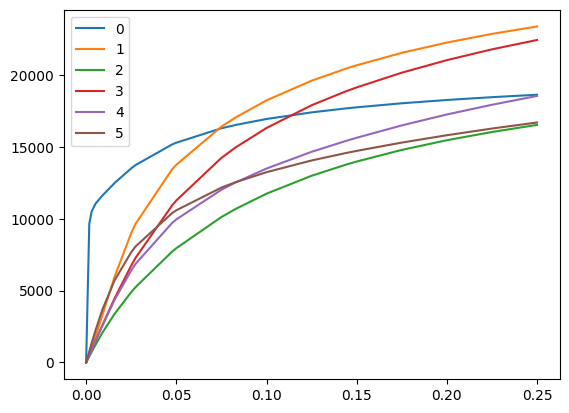

In [21]:
for i, r in enumerate(results):
    # plt.plot(contrasts[:-5], r, label=i)
    plt.plot(contrasts, r, label=i)
    # plt.plot(r)
plt.legend()
plt.show()

### Prop 10

In [22]:
import numpy as np
data = np.load("/Users/jorgvt/Developer/visturing/Data/Experiment_10/gabor_low_achrom.npy")
contrasts = np.load("/Users/jorgvt/Developer/visturing/Data/Experiment_10/contrasts.npy")
print(data.shape)
print(contrasts)

(8, 20, 256, 256, 3)
[0.         0.00173698 0.00301709 0.00524061 0.00910282 0.01581139
 0.025      0.02746401 0.04770435 0.05       0.075      0.08286135
 0.1        0.125      0.14392824 0.15       0.175      0.2
 0.225      0.25      ]


In [23]:
results = []

for dat in tqdm(data):
    dat = rgb2atd(dat)
    # pred, extras = model.apply({"params": params, **state}, dat, train=True, mutable=list(state.keys()), capture_intermediates=True)
    # diff = ((pred - pred[0:1])**2).sum(axis=(1,2,3))**(1/2)
    # diff = calculate_diffs(dat, dat[0:1])
    diff = calculate_diffs(dat, dat[0:1])
    results.append(diff)
    # break


100%|██████████| 8/8 [00:01<00:00,  6.52it/s]


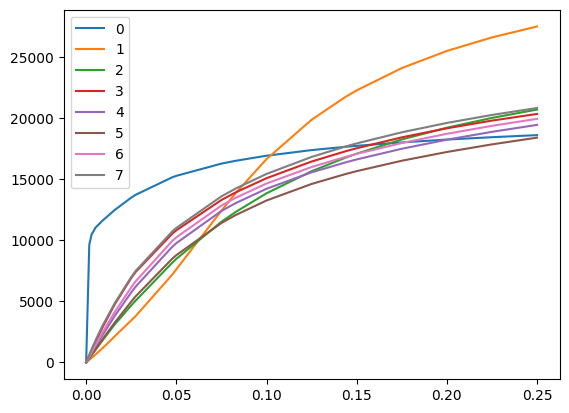

In [24]:
for i, r in enumerate(results):
    # plt.plot(contrasts[:-5], r, label=i)
    plt.plot(contrasts, r, label=i)
    # plt.plot(r)
plt.legend()
plt.show()